# This notebook 
## 1. Calculates the alignment between coastal normal vectors and ERA 5 wind velocity vectors
## 2. Explores the correlation between normal/velocity vector alignment and probability of beaching

In [2]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [3]:
# dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from tqdm import tqdm

import scipy.interpolate as sci_int
import scipy.stats as sci_stats
import geopandas as gpd

from scipy.ndimage import gaussian_filter,  generic_filter

In [4]:
# set plotting text size parameters
plt.rcParams.update({
    'axes.titlesize': 30,
    'axes.labelsize': 24, 
    'xtick.labelsize': 18,  
    'ytick.labelsize': 18,  
    'legend.fontsize': 18, 
    'figure.titlesize': 28})

In [5]:
# load u and v coastal norm component CSVs:
u_df = pd.read_csv('u_df.csv')
v_df = pd.read_csv('v_df.csv')

# load wind CSV:
avg_u_winds = pd.read_csv('avg_u_winds.csv')
avg_v_winds = pd.read_csv('avg_v_winds.csv')

# load probability of beaching data
beach_undrogued = pd.read_csv('undrogued_beach.csv')
unbeach_undrogued = pd.read_csv('undrogued_unbeach.csv')

### First we need to reduce the dimensions of the wind data by averaging:

In [6]:
def df_aggregation_by_factor_8(df):
    # keep original df unaffected
    working_df = df.copy()

    # initialize row mean:
    row_means = []
    
    # for each odd row    
    for i in tqdm(range(0, len(working_df), 2)):

        # initialize column mean:
        col_means = []
        
        # for each odd col
        for j in range(0, len(working_df.columns), 2):  

            # get 3x3 matrix around current grid cell
            matrix = working_df.iloc[i-1:i+2, j-1:j+2].values
            
            # get mean of matrix
            matrix_mean = matrix.mean()
            
            col_means.append(matrix_mean)
            
        row_means.append(col_means)
        
    result_df = pd.DataFrame(row_means)
    
    return result_df

In [7]:
# define desired rows and desired cols
desired_rows = 360
desired_cols = 180

# perform aggregation on wind dfs:
#u_winds = df_aggregation_by_factor_8(df_aggregation_by_factor_8(df_aggregation_by_factor_8(avg_u_winds.iloc[:-1,:])))
#v_winds = df_aggregation_by_factor_8(df_aggregation_by_factor_8(df_aggregation_by_factor_8(avg_v_winds.iloc[:-1,:])))
u_winds = df_aggregation_by_factor_8(df_aggregation_by_factor_8(avg_u_winds.iloc[:-1,:]))
v_winds = df_aggregation_by_factor_8(df_aggregation_by_factor_8(avg_v_winds.iloc[:-1,:]))

# flip vertically
u_winds = u_winds.iloc[::-1]
v_winds = v_winds.iloc[::-1]

# shift 180 degrees lon
u_winds =  pd.concat([u_winds.iloc[:, u_winds.shape[1] // 2:], u_winds.iloc[:, :u_winds.shape[1] // 2]], axis=1)
v_winds =  pd.concat([v_winds.iloc[:, v_winds.shape[1] // 2:], v_winds.iloc[:, :v_winds.shape[1] // 2]], axis=1)

  0%|          | 0/360 [00:00<?, ?it/s]/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 180/180 [00:06<00:00, 27.69it/s]


In [8]:
# define lat and lon
lats = np.linspace(-90,90,desired_cols)[30:-30]
lons = np.linspace(-180, 180, desired_rows)

In [9]:
# remove beyond -70 and 70 degrees lat:
u_winds1 = u_winds[30:-30] # 60 lat or 65?
v_winds1 = v_winds[30:-30]
#u_winds1 = u_winds
#v_winds1 = v_winds

In [10]:
np.shape(u_df[20:-20])

(120, 360)

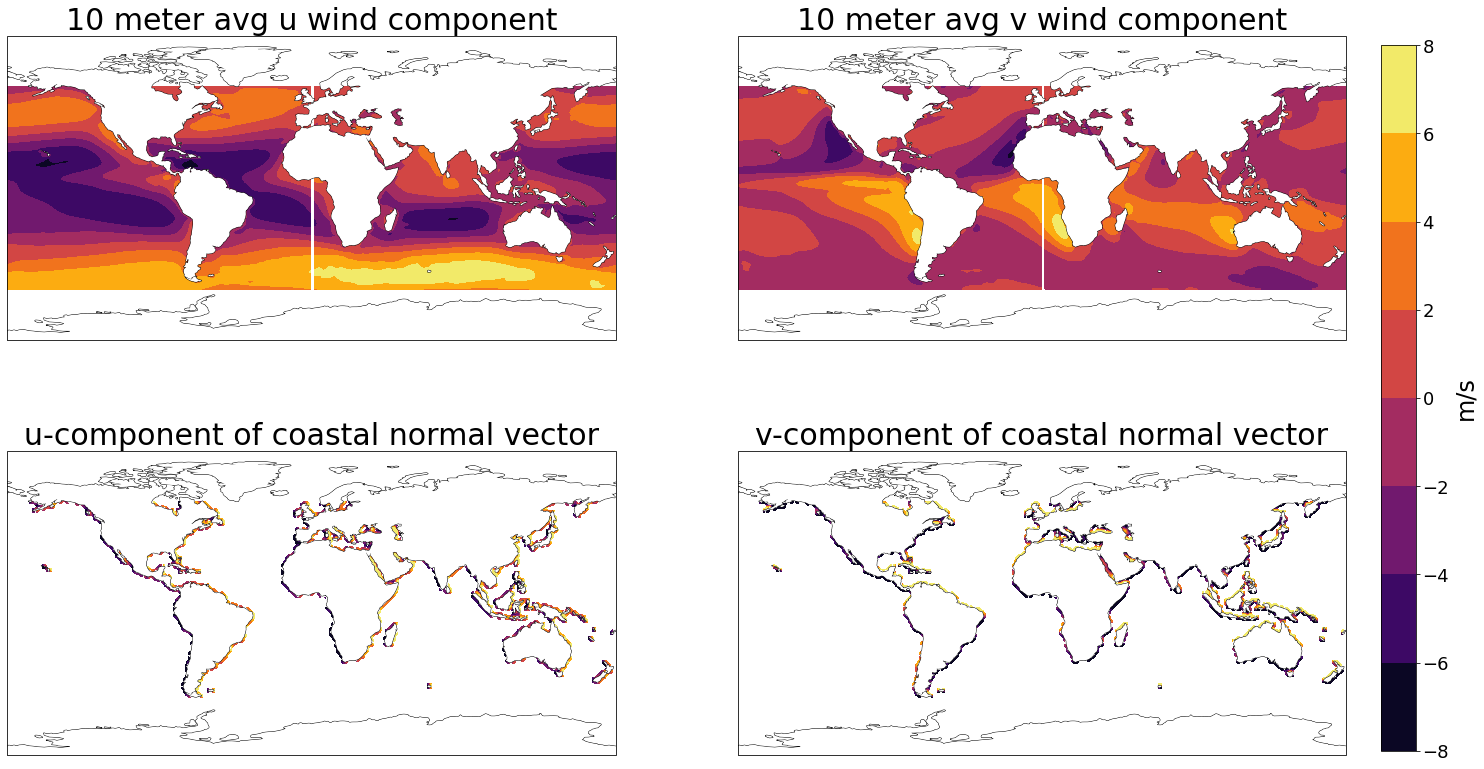

In [11]:
# visualize wind and normal vector components
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 14),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

# Plot the u-component of wind
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, u_winds1, cmap='inferno', transform=ccrs.PlateCarree())
ax1.set_title('10 meter avg u wind component')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Plot the v-component of wind
ax2.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im2 = ax2.contourf(lons, lats, v_winds1, cmap='inferno', transform=ccrs.PlateCarree())
ax2.set_title('10 meter avg v wind component')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

ax2.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax2.add_feature(land_feature)

# Plot the u-component of coastal normal vector
ax3.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im3 = ax3.contourf(lons, lats, u_df[20:-20], cmap='inferno', transform=ccrs.PlateCarree())
ax3.set_title('u-component of coastal normal vector')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

ax3.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax3.add_feature(land_feature)

# Plot the v-component of coastal normal vector
ax4.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im4 = ax4.contourf(lons, lats, v_df[20:-20], cmap='inferno', transform=ccrs.PlateCarree())
ax4.set_title('v-component of coastal normal vector')
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')

ax4.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax4.add_feature(land_feature)

# Create a single colorbar for both plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im2, cax=cbar_ax, label='m/s')

# Adjust layout
plt.subplots_adjust(wspace=0.2, right=0.9)  # wspace for width space, right to make space for colorbar

# Show the plot
plt.show()

### Now we calculate the alignment of the coastal normal vectors and wind vectors:

In [12]:
# get u and v components of coastal norms and wind velocity
u_df_array = u_df[20:-20].values
v_df_array = v_df[20:-20].values
u_winds_array = u_winds1.values
v_winds_array = v_winds1.values

In [13]:
np.shape(v_df_array)

(120, 360)

In [14]:
positions = []

u_list = []
v_list = []

u_winds_list = []
v_winds_list = []

# Iterate over the dataframes to extract non-NaN values and their positions
for i in range(u_df[20:-20].shape[0]):
    for j in range(u_df[20:-20].shape[1]):
        if not np.isnan(u_df[20:-20].iat[i, j]) and not np.isnan(v_df[20:-20].iat[i, j]):
            u = u_df[20:-20].iat[i, j]
            v = v_df[20:-20].iat[i, j]
            u_wind = u_winds1.iat[i, j]
            v_wind = v_winds1.iat[i, j]
            
            # Store the position and the vector components
            positions.append((i, j))
            u_list.append(u)
            v_list.append(v)
            
            u_winds_list.append(u_wind)
            v_winds_list.append(v_wind)

In [15]:
np.shape(positions)

(2575, 2)

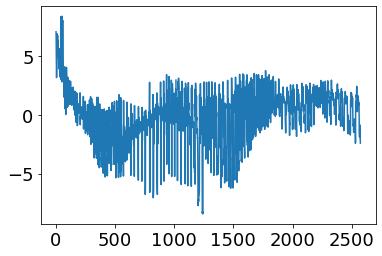

In [16]:
plt.plot(u_winds_list)

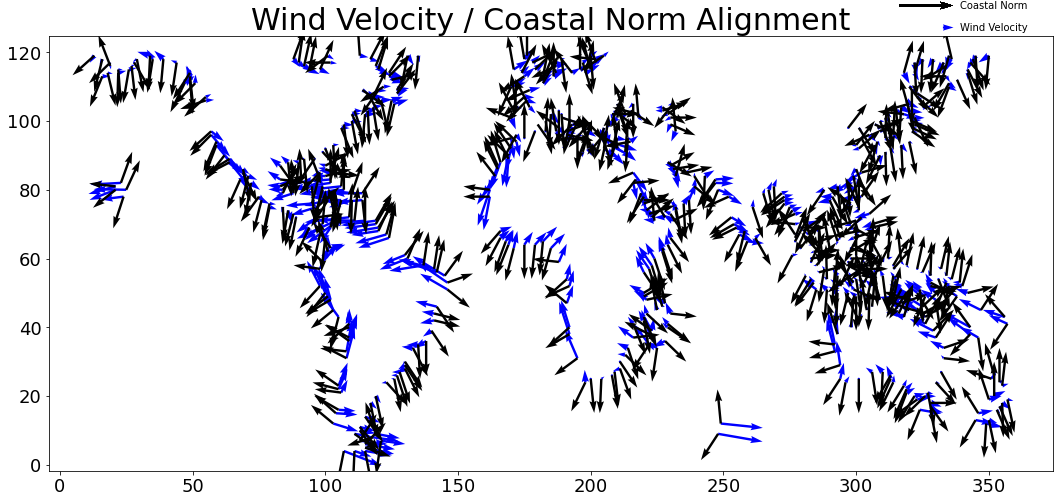

In [17]:
# visualize alignment
fig, ax = plt.subplots(1, 1, figsize=(18, 8))


# convert positions to X and Y arrays
positions = np.array(positions)
X, Y = positions[:, 1], positions[:, 0]

# Plot wind vectors where coastal norms are non-NaN
wind_q = ax.quiver(X[::4], Y[::4], u_winds_list[::4], v_winds_list[::4], color='blue', scale=190)

# Plot coastal norm vectors where coastal norms are non-NaN
coast_norm_q = ax.quiver(X[::4], Y[::4], u_list[::4], v_list[::4], angles = 'xy', scale_units = 'xy', scale = 0.1)

ax.set_title('Wind Velocity / Coastal Norm Alignment')


# Add a legend
ax.quiverkey(wind_q, 0.9, 1.02, 2, 'Wind Velocity', color='blue', labelpos='E')
ax.quiverkey(coast_norm_q, 0.9, 1.07, 2, 'Coastal Norm', color='k', labelpos='E')

# Show the plot
plt.show()

In [18]:
# compute dot product of coastal normal vectors and wind velocity vectors
dot_product = np.array(u_winds_list) * np.array(u_list) + np.array(v_winds_list) * np.array(v_list)
dot_product = dot_product / np.sqrt(np.array(u_winds_list)**2 + np.array(v_winds_list)**2)
# Create an empty DataFrame with the desired shape (70, 180)
rows, cols = 120, 360
alignment = pd.DataFrame(np.nan, index=np.arange(rows), columns=np.arange(cols))

# Convert dot_product to 1D array if it's not already
dot_product = dot_product.flatten()

# Fill the DataFrame with the dot product values at the corresponding positions
for (i, j), value in zip(positions, dot_product):
    alignment.iat[i, j] = value



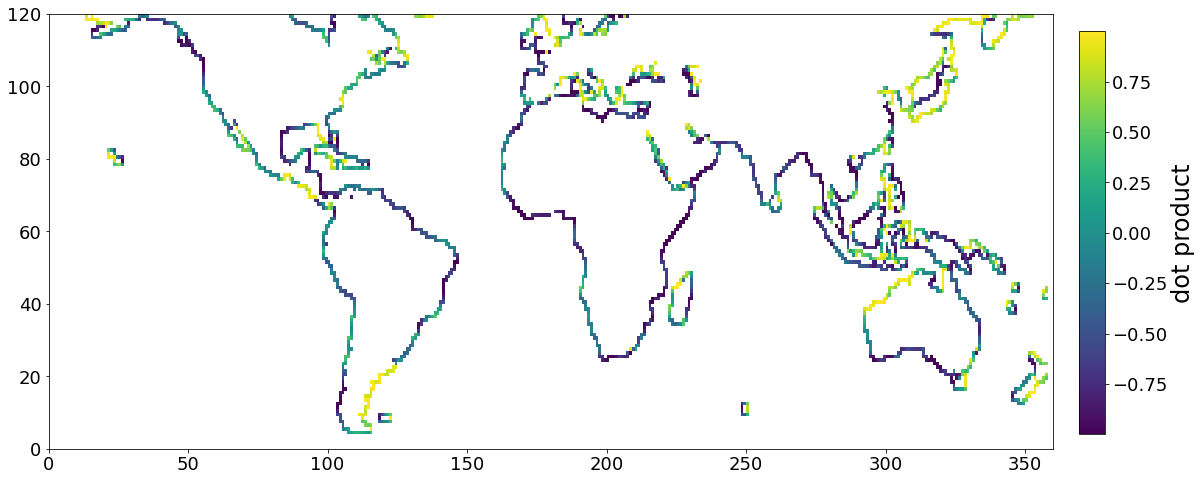

In [19]:
# visualize alignment
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 8))


im1 = ax1.pcolormesh(alignment,cmap='viridis')



# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='dot product')

# Show the plot
plt.show()

### Let's compare these alignments to the probability of beaching in those grid cells

In [20]:
# we follow the steps in the probability of beaching notebook:
# get beached lats and lons
beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])


In [21]:
# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

In [22]:
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability

In [23]:
probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat).T

# put into 'beach_prob' dataframe and remove data past -70 and 70 degrees lat:
beach_prob = pd.DataFrame(probability_undrogued)#.iloc[30:-30]
beach_prob_vals = beach_prob.values

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


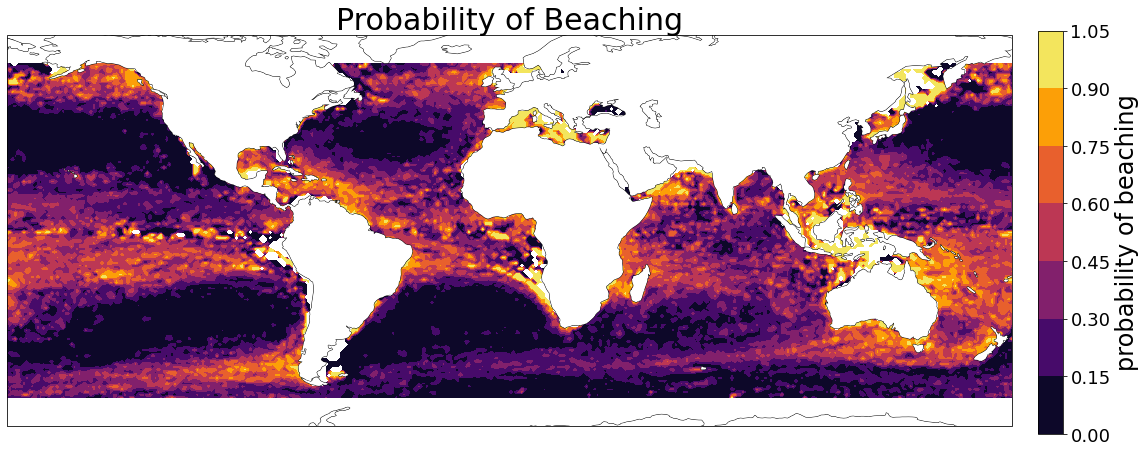

In [24]:
# visualize probability of beaching
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 8),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})


ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, beach_prob_vals, cmap='inferno', transform=ccrs.PlateCarree())
ax1.set_title('Probability of Beaching')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='probability of beaching')

# Show the plot
plt.show()

In [25]:
from scipy.ndimage import generic_filter

def average_surrounding_cells(df, layers=3, strength=0.8):
    # Define the footprint for the filter
    size = 2 * layers + 1
    
    # Custom function to apply within the filter
    def mean_filter(values):
        valid_values = values[~np.isnan(values)]
        if valid_values.size == 0:
            return np.nan
        return np.mean(valid_values) * strength + values[size**2 // 2] * (1 - strength)
    
    # Apply the generic filter
    averaged_data = generic_filter(df.to_numpy(), mean_filter, size=size, mode='constant', cval=np.nan)
    
    return pd.DataFrame(averaged_data, index=df.index, columns=df.columns)

In [26]:
smoothed_beach_prob = average_surrounding_cells(beach_prob)
smoothed_beach_prob_vals = smoothed_beach_prob.values

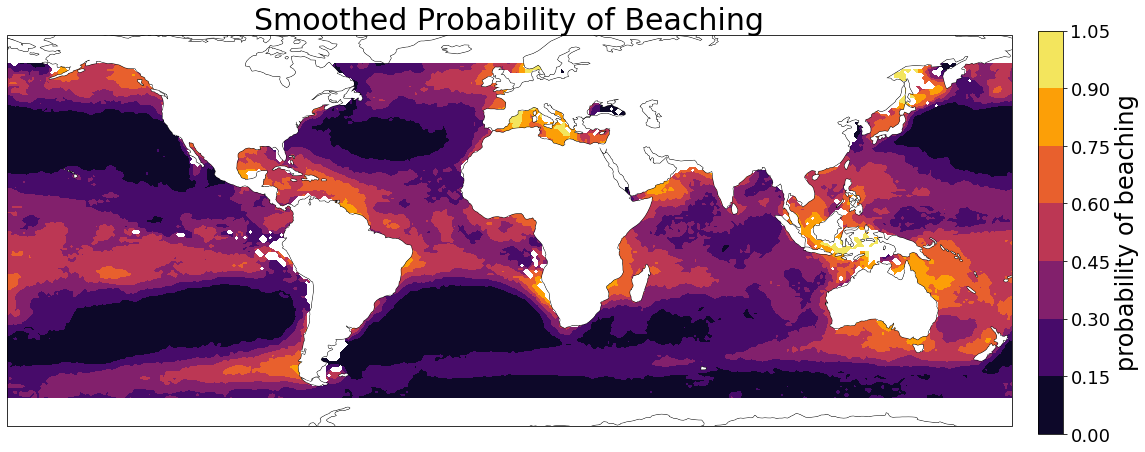

In [27]:
# visualize smoothed probability of beaching
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 8),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})


ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, smoothed_beach_prob_vals, cmap='inferno', transform=ccrs.PlateCarree())
ax1.set_title('Smoothed Probability of Beaching')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='probability of beaching')

# Show the plot
plt.show()

#### So at every location that is coastal (has a non_NAN 'alignment' value), we want to see what the probability of beaching is

In [28]:
# initialize output lists
beach_prob_list = []
alignment_list = []

# through rows
for i in range(alignment.shape[0]):
    
    # through cols
    for j in range(alignment.shape[1]):
        
        # if not NAN
        if not np.isnan(alignment.iloc[i, j]):
            
            # append value from beach_prob and alignment to their list
            beach_prob_list.append(smoothed_beach_prob.iloc[i, j])
            alignment_list.append(alignment.iloc[i, j])

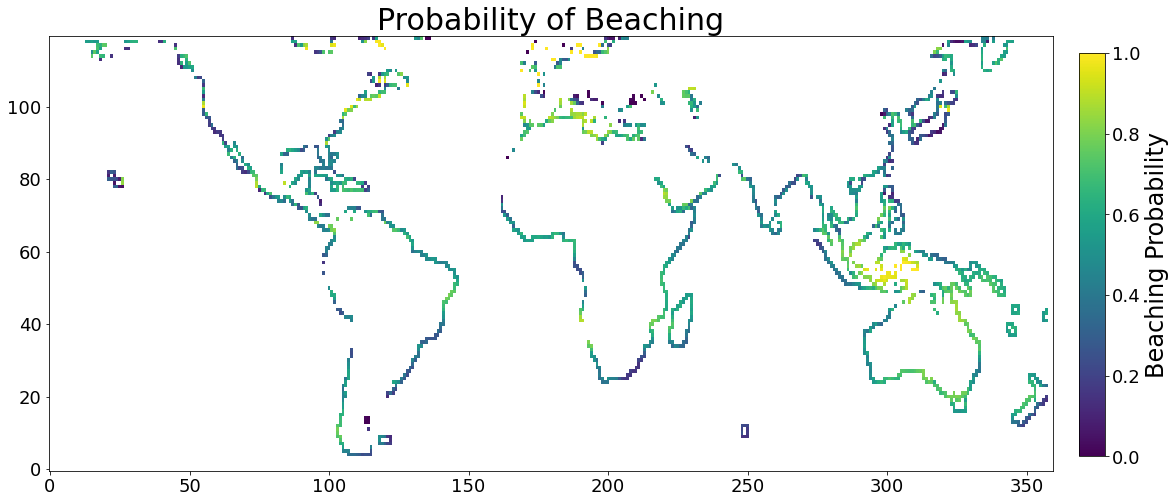

In [29]:
# Create an empty DataFrame with the same shape as alignment
beach_prob_df = pd.DataFrame(np.nan, index=alignment.index, columns=alignment.columns)

# Fill the DataFrame with the beach_prob_list values at the corresponding positions
for (i, j), value in zip(positions, beach_prob_list):
    beach_prob_df.iat[i, j] = value

# Plotting
fig, ax1 = plt.subplots(1, 1, figsize=(18, 8))


# Create the meshgrid for plotting
lon, lat = np.meshgrid(beach_prob_df.columns, beach_prob_df.index)

# Plot the data using pcolormesh
im1 = ax1.pcolormesh(lon, lat, beach_prob_df, cmap='viridis')

ax1.set_title('Probability of Beaching')

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='Beaching Probability')


# convert positions to X and Y arrays
#positions = np.array(positions)
#X, Y = positions[:, 1], positions[:, 0]

# Plot wind vectors where coastal norms are non-NaN
#wind_q = ax1.quiver(X[::4], Y[::4], u_winds_list[::4], v_winds_list[::4], color='blue', scale=400)

# Plot coastal norm vectors where coastal norms are non-NaN

#coast_norm_q = ax1.quiver(X[::4], Y[::4], u_list[::4], v_list[::4], angles = 'xy', scale_units = 'xy', scale = 0.6)

#ax.set_title('Wind Velocity / Coastal Norm Alignment')


# Add a legend
#ax1.quiverkey(wind_q, 0.9, 1.02, 2, 'Wind Velocity', color='blue', labelpos='E')
#ax1.quiverkey(coast_norm_q, 0.9, 1.07, 2, 'Coastal Norm', color='k', labelpos='E')

# Show the plot
plt.show()

In [30]:
# id nan indices
nan_indices = np.isnan(np.array(alignment_list)) | np.isnan(np.array(beach_prob_list))

# remove nans
alignment_list_f = np.array(alignment_list)[~nan_indices]
beach_prob_list_f = np.array(beach_prob_list)[~nan_indices]

# fit a line:
coefficients  = np.polyfit(alignment_list_f, beach_prob_list_f, 1)
predicted_values = np.polyval(coefficients, alignment_list_f)
#coefficients  = np.polyfit(beach_prob_list_f,alignment_list_f, 1)
#predicted_values = np.polyval(coefficients, beach_prob_list_f)

# calculate r2
p = np.poly1d(coefficients)
r_squared = np.corrcoef(beach_prob_list_f, p(alignment_list_f))[0, 1] ** 2

In [31]:
r_squared

0.032223855164294185

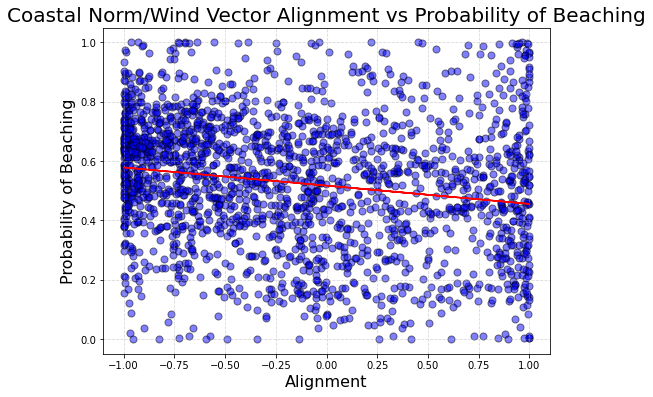

In [32]:

# visualize correlation between the two
plt.figure(figsize=(8, 6))
plt.scatter(alignment_list, beach_prob_list, s=50, c='blue', alpha=0.5, edgecolors='k')
plt.plot(alignment_list_f, predicted_values, color='r', linestyle='-', label='Fitted Line')

plt.grid(True, linestyle='--', alpha=0.5)

plt.xlabel('Alignment', fontsize=16)
plt.ylabel('Probability of Beaching', fontsize=16)

plt.tick_params(axis='both', which='both', labelsize=10)

plt.title('Coastal Norm/Wind Vector Alignment vs Probability of Beaching', fontsize=20)

plt.show()

### apply uniform rotation to winds to check ekman 
### map of ocean currents and winds, correlation to stuff

# to try: guassian filter. larger probability beaching grid cells: get coherent blobs of probability

In [33]:
lats = np.linspace(-90,90,desired_cols)#[10:-10]
lons = np.linspace(-180, 180, desired_rows)
u_winds_array
v_winds_array

array([[-1.26994239, -1.25610266, -1.24252254, ..., -1.29054062,
        -1.30142579, -1.29001519],
       [-1.35707059, -1.31218972, -1.26078276, ..., -1.35709595,
        -1.38067925, -1.38327906],
       [-1.3542381 , -1.27365705, -1.20582313, ..., -1.43357306,
        -1.43519827, -1.41446354],
       ...,
       [-1.17175118, -1.15796867, -1.14674414, ..., -1.19756624,
        -1.19437046, -1.18595246],
       [-1.42830009, -1.42726502, -1.4271772 , ..., -1.4524686 ,
        -1.44436543, -1.43686059],
       [-1.74703611, -1.7435808 , -1.72205195, ..., -1.72985113,
        -1.7229883 , -1.73836847]])

In [38]:
np.shape(beach_prob_vals)

(120, 360)

In [39]:
probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat).T

# put into 'beach_prob' dataframe and remove data past -70 and 70 degrees lat:
beach_prob = pd.DataFrame(probability_undrogued)#.iloc[30:-30]
beach_prob_vals = beach_prob.values

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [44]:
# remove beyond -70 and 70 degrees lat:
u_winds1 = u_winds # 60 lat or 65?
v_winds1 = v_winds

In [45]:
# get u and v components of coastal norms and wind velocity
u_df_array = u_df[20:-20].values
v_df_array = v_df[20:-20].values
u_winds_array = u_winds1.values
v_winds_array = v_winds1.values

In [46]:
os.chdir('/home/openonic/global-drifter-program/')

In [51]:
def nan_gaussian_filter(values, sigma=0.45):
    mask = np.isnan(values)
    values_filled = np.where(mask, np.nanmean(values), values)  # Replace NaNs with the mean of non-NaNs
    filtered = gaussian_filter(values_filled, sigma=sigma)
    filtered[mask] = np.nan  # Restore NaNs
    return filtered

# Apply the custom Gaussian filter
beach_prob_vals_filtered = nan_gaussian_filter(beach_prob_vals, sigma=0.7)

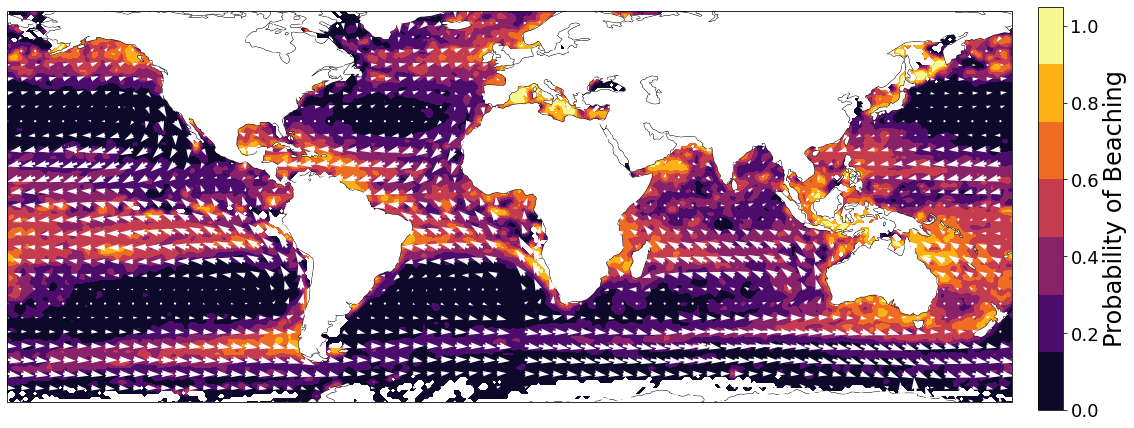

In [53]:
# visualize probability of beaching
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 8),
                          subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, beach_prob_vals_filtered, cmap='inferno', transform=ccrs.PlateCarree(), vmin=0, vmax=1.0, levels = 6)
#ax1.set_title('Probability of Beaching')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color='black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, label='Probability of Beaching')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
im1.set_clim(0, 1.0)  # This sets the color limits for the ScalarMappable


# Plot wind vectors
wind_q_global = ax1.quiver(lons[::5], lats[::5], u_winds_array[::5,::5], v_winds_array[::5,::5], color='white', scale=500)

plt.savefig('prob_beach_winds.png', dpi=300)

# Show the plot
plt.show()

# new note 6/25: only consider zonal component of coastal normal vector

## make figure above but for ocean currents (aviso\duacs geostrophic currents) talk to scott

## coastal grid: numerator is number of drifters that beached in that grid box, denominator is all drifters that were ever in that box

In [86]:
last_points

,id,time,lat,lon,ve,vn,time_to_beach
0,101509,1331078400,13.71750,124.71663,-0.1732,-0.0036,0.0
102,101510,1328504400,22.35016,120.59885,0.0015,0.1483,0.0
120,101512,1328720400,20.67819,121.05971,-0.3422,1.1730,0.0
143,101519,1330207200,24.75619,125.47094,0.0689,-0.2081,0.0
3824,101534,1345708800,8.58603,-13.21257,0.1051,-0.0605,0.0
...,...,...,...,...,...,...,...
23060933,9915124,930420000,65.89437,-24.21946,-0.0359,-0.1442,0.0
23060957,9915757,937522800,37.42537,129.32630,0.0116,0.0080,0.0
23061290,9915941,937814400,38.26993,128.64050,-0.1522,-0.5818,0.0
23068083,9917894,995828400,-15.46437,167.69762,0.0298,-0.0163,0.0


In [87]:
# get the number of drifters that beached in a given grid box
# get beaching coords
last_points = beach_undrogued.drop_duplicates(subset='id', keep='last')

# get lats and lons
beach_last_undrogued_lats = np.array(last_points['lat'])
beach_last_undrogued_longs = np.array(last_points['lon'])

beach_last_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_last_undrogued_longs,beach_last_undrogued_lats,values = last_points['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# sum beach_undrogued_stat and unbeach_undrogued_stat 
# to get number of drifters that were ever in that box
summed_undrogued_stat = beach_undrogued_stat + unbeach_undrogued_stat

In [88]:
np.shape(summed_undrogued_stat)

(360, 180)

In [89]:
np.shape(beach_last_undrogued_stat)

(360, 180)

In [92]:
probability_undrogued_last = (beach_last_undrogued_stat / summed_undrogued_stat).T

# put into 'beach_prob' dataframe and remove data past -70 and 70 degrees lat:
beach_prob_last = pd.DataFrame(probability_undrogued_last).iloc[30:-30]
beach_prob_vals_last = beach_prob_last.values

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


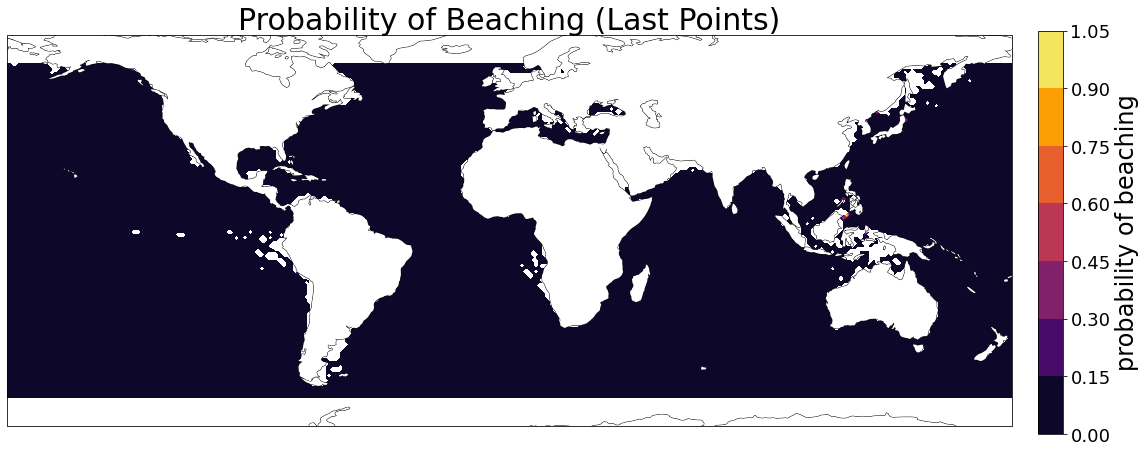

In [93]:
# visualize probability of beaching
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 8),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})


ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, beach_prob_vals_last, cmap='inferno', transform=ccrs.PlateCarree())
ax1.set_title('Probability of Beaching (Last Points)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='probability of beaching')

# Show the plot
plt.show()

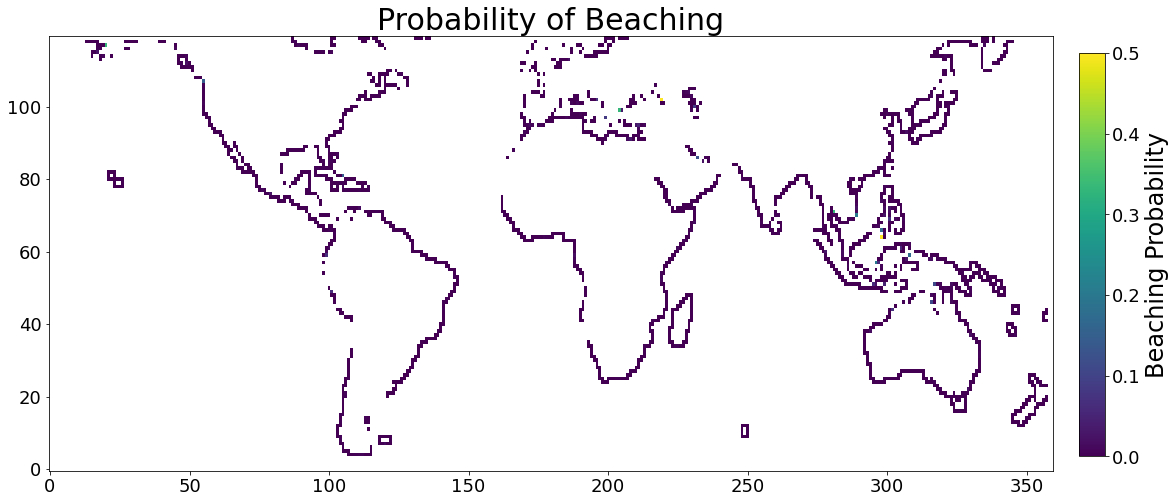

In [108]:
# initialize output lists
beach_prob_list = []
alignment_list = []

# through rows
for i in range(alignment.shape[0]):
    
    # through cols
    for j in range(alignment.shape[1]):
        
        # if not NAN
        if not np.isnan(alignment.iloc[i, j]):
            
            # append value from beach_prob and alignment to their list
            beach_prob_list.append(beach_prob_last.iloc[i, j])
            alignment_list.append(alignment.iloc[i, j])

# Create an empty DataFrame with the same shape as alignment
beach_prob_df = pd.DataFrame(np.nan, index=alignment.index, columns=alignment.columns)

# Fill the DataFrame with the beach_prob_list values at the corresponding positions
for (i, j), value in zip(positions, beach_prob_list):
    beach_prob_df.iat[i, j] = value

# Plotting
fig, ax1 = plt.subplots(1, 1, figsize=(18, 8))


# Create the meshgrid for plotting
lon, lat = np.meshgrid(beach_prob_df.columns, beach_prob_df.index)

# Plot the data using pcolormesh
im1 = ax1.pcolormesh(lon, lat, beach_prob_df, cmap='viridis')

ax1.set_title('Probability of Beaching')

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='Beaching Probability')


# convert positions to X and Y arrays
#positions = np.array(positions)
#X, Y = positions[:, 1], positions[:, 0]

# Plot wind vectors where coastal norms are non-NaN
#wind_q = ax1.quiver(X[::4], Y[::4], u_winds_list[::4], v_winds_list[::4], color='blue', scale=400)

# Plot coastal norm vectors where coastal norms are non-NaN

#coast_norm_q = ax1.quiver(X[::4], Y[::4], u_list[::4], v_list[::4], angles = 'xy', scale_units = 'xy', scale = 0.6)

#ax.set_title('Wind Velocity / Coastal Norm Alignment')


# Add a legend
#ax1.quiverkey(wind_q, 0.9, 1.02, 2, 'Wind Velocity', color='blue', labelpos='E')
#ax1.quiverkey(coast_norm_q, 0.9, 1.07, 2, 'Coastal Norm', color='k', labelpos='E')

# Show the plot
plt.show()

0.0009539296684028025


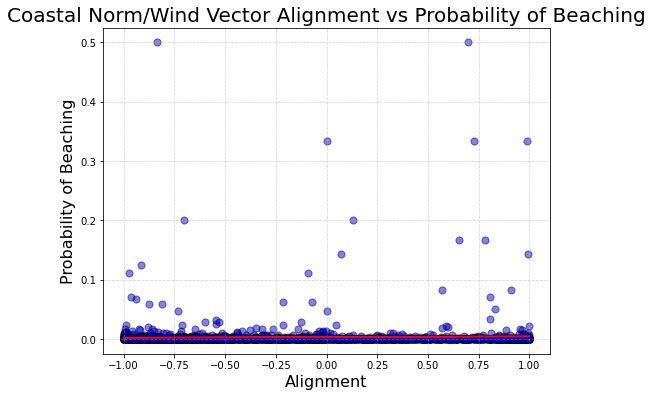

In [109]:
# id nan indices
nan_indices = np.isnan(np.array(alignment_list)) | np.isnan(np.array(beach_prob_list))

# remove nans
alignment_list_f = np.array(alignment_list)[~nan_indices]
beach_prob_list_f = np.array(beach_prob_list)[~nan_indices]

# fit a line:
coefficients  = np.polyfit(alignment_list_f, beach_prob_list_f, 1)
predicted_values = np.polyval(coefficients, alignment_list_f)
#coefficients  = np.polyfit(beach_prob_list_f,alignment_list_f, 1)
#predicted_values = np.polyval(coefficients, beach_prob_list_f)

# calculate r2
p = np.poly1d(coefficients)
r_squared = np.corrcoef(beach_prob_list_f, p(alignment_list_f))[0, 1] ** 2

print(r_squared)


# visualize correlation between the two
plt.figure(figsize=(8, 6))
plt.scatter(alignment_list, beach_prob_list, s=50, c='blue', alpha=0.5, edgecolors='k')
plt.plot(alignment_list_f, predicted_values, color='r', linestyle='-', label='Fitted Line')

plt.grid(True, linestyle='--', alpha=0.5)

plt.xlabel('Alignment', fontsize=16)
plt.ylabel('Probability of Beaching', fontsize=16)

plt.tick_params(axis='both', which='both', labelsize=10)

plt.title('Coastal Norm/Wind Vector Alignment vs Probability of Beaching', fontsize=20)

plt.show()